# Introduction
In this project, we are designing a controller that will balance a pendulum upright. This is exactly like trying to balance an upright pencil in the palm of your hand by moving your hand around. In this problem, a mass is attached to the end of a rigid, massless rod. This rod is then pinned to a cart and allowed to rotate freely. The cart has four wheels all of which roll without slipping on a horizontal surface. Torque can be applied to each wheel, and this allows to cart to traverse side to side. This action will be used to balance the pendulum upright. To solve this problem, we are taking an approach called "model-based controls". This means that our controller design will be based on a model of the dynamics of the system. The first step, then, is to use the Lagrangian mechanics formulation to derive the equations of motion.

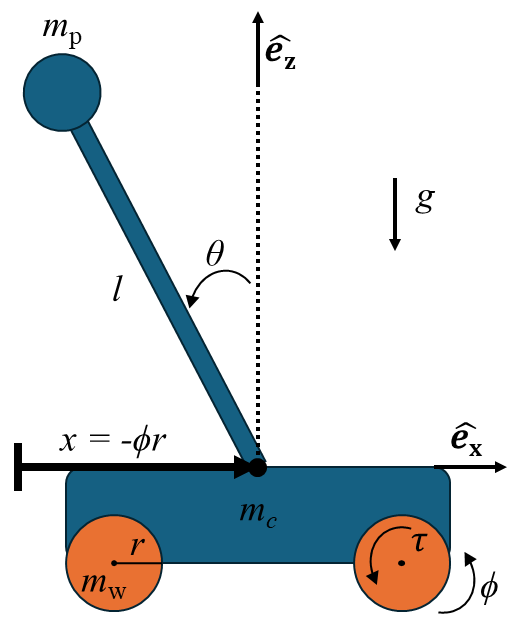

# System Dynamics and Equations of Motion
This is the model of the cart. There are two generalized coordinates: $\theta$ (the pendulum angle) and $\phi$ (the wheel angle). Because we assume that all the wheels are rolling without slipping, each wheel has the same angle. Further, the $x$ coordinate of the cart can be expressed in terms of the wheel angle and the radius of the wheels, $r$. Lastly, the input to the system is some torque, $\tau$, that is applied equally to all the wheels.

The first step in the Lagrangian mechanics approach is to calculate the total kinetic energy of the system and the total potential energy of the system with respect to the generalized coordinates and their derivatives. We can do this using the Python package Sympy.

In [ ]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix, Function, Derivative, N
from sympy import diff, simplify, sin, cos, solve, init_printing, symbols, lambdify
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

Now we are going to define the parameters of the system as constants:

In [ ]:
# Constants of the system
mp = 1.0
mc = 2.0
mw = 0.25
l = 1.0
r = 0.25
g = 9.81

Now we make symbols and functions. These are elements of SymPy and can be thought of as exactly the same as symbols (variables) and functions from math.

In [ ]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time.
# This means that they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau')

Now we will start to calculate the energies of the system. We can start by getting the kinetic energy of the mass on top of the pendulum. We can do this by:
1. Defining its position in terms of the generalized coordinates
2. Take the derivate of the position with respect to time to get the velocity
3. Calculate the kinetic energy from the velocity
4. Calculate the potential energy by observation

In [ ]:
# Get the position of the mass in terms of phi and theta
pos = Matrix([-r*phi(t) - l*sin( theta(t) ),
              0.0,
              l*cos( theta(t) )])

In [ ]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [ ]:
# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

In [ ]:
# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

Because the connecting rod of the pendulum has no mass nor mass moment of inertia, we can move on the the energy of the cart. The cart does not change height, so we can just set its potential energy to 0. This means all we have to do is calculate the kinetic energy.

In [ ]:
# Get the position of the cart in terms of phi and theta
pos = Matrix([-phi(t)*r,
              0.0,
              0.0])

In [ ]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [ ]:
# Get the kinetic energy of the cart from the velocity
cart_KE = 0.5 * mc * (vel.T @ vel)[0,0]

Next up, the wheels. For the same reason as the cart, we set their potential energy to 0 also. This means we just need to calculate thier kinetic and rotational energy. Also, while calculating the position, we will ignore the constant offsets that each of the four wheels have (length and width of the wheel base). We can do this because constants disappear during differentiation.

In [ ]:
# Get the position of the wheels in terms of phi and theta
pos = Matrix([-phi(t)*r,
              0.0,
              0.0])

In [ ]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [ ]:
# Get the kinetic energy of all four wheels from the velocity
wheel_KE = 4.0 * (0.5 * mw * (vel.T @ vel)[0,0])

In [ ]:
# Get the rotational kinetic energy of all four wheels
I = 0.5*mw*r**2
wheel_RE = 4.0*(I*diff(phi(t),t)**2)

Now we calculate the lagrangian of the system via the formula:$$L=T-V$$ where $T$ is the total kinetic energy and $V$ is the total potential energy.

In [ ]:
# Get the lagrangian
L = (mass_KE + cart_KE + wheel_KE + wheel_RE) - mass_PE
print("System Lagrangian:")
L = simplify(L)
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

Finally, we get the equations of motion of the system via the formulas:
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta}=0$$
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\phi}} \right) - \frac{\partial L}{\partial \phi}=\tau$$

In [ ]:
# Get the first equation of motion
f1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

In [ ]:
# Get the second equation of motion
f2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - 4.0*tau(t)

Currently, the equations of motion are in the form:
$$
f_1 \left( \frac{\partial^{2} \theta}{\partial t^{2}}, \frac{\partial^{2} \phi}{\partial t^{2}}, \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right) = 0
$$
$$
f_2 \left( \frac{\partial^{2} \theta}{\partial t^{2}}, \frac{\partial^{2} \phi}{\partial t^{2}}, \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right) = 0
$$

This form of equations of motion is not very helpful to us right now, so next we will place them in the form:
$$
\frac{\partial^{2} \theta}{\partial t^{2}} = f_{\theta} \left( \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right)
$$
$$
\frac{\partial^{2} \phi}{\partial t^{2}} = f_{\phi} \left( \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right)
$$

In [ ]:
# Solve the first two equations of motion for the second order derivatives
soln = solve([f1, f2],
             Derivative(theta(t), (t, 2)),
             Derivative(phi(t), (t, 2)))
soln = simplify(soln)
f_theta = soln[Derivative(theta(t), (t, 2))]
f_phi = soln[Derivative(phi(t), (t, 2))]

Let's now combine these two equations into a single vector and replace the functions of time with symbols (this will make the linearization steps easier).

In [ ]:
# Build the equations of motion vector
f = Matrix([f_theta,
            f_phi])

# Replace the functions of time with symbols
(v1, v2, v3, v4, v5) = symbols('v1, v2, v3, v4, v5')
f = f.subs({Derivative(theta(t), t) : v1,
            Derivative(phi(t), t) : v2,
            theta(t) : v3,
            phi(t) : v4,
            tau(t) : v5})
(thetadot, phidot, theta, phi, tau) = symbols('thetadot, phidot, theta, phi, tau')
f = f.subs({v1 : thetadot,
            v2 : phidot,
            v3 : theta,
            v4 : phi,
            v5 : tau})

# Simplify
f = simplify(f)

$f$ is our system model such that:
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} = f(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau)
$$
Note that both of these ODEs are second-order — you will have to replace them each with a set of two first-order ODEs, as usual.

In [ ]:
N(f, 3) # This rounds floating point number to 3 places and then prints to the screen

# System Linearization and State Space Form

In [ ]:
# >>>>>FIXME<<<<<: Place the system in standard form, linearize it, and calculate the A and B matrices.

# Gain Selection and Controller Design

In [ ]:
# >>>>>FIXME<<<<<: Guess a gain matrix and ensure the closed-loop system is stable.

In [ ]:
# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # >>>>>FIXME<<<<<: Replace the following with your own __init__ function
        pass
        
    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any member variable
        that tracks states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # >>>>>FIXME<<<<<: Replace the following your own reset function
        pass 

    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["pendulum_angle"] : Float
                The current angle of the pendulum in radians (theta)  -- theta

            kwargs["wheel_angle"] : Float
                The current target angle of the wheels in radians (phi) -- phi

            kwargs["pendulum_velocity"] : Float
                The current angular velocity of the pendulum in radians/second -- thetadot

            kwargs["wheel_velocity"] : Float
                The current target angular velocity of the wheels in radians/second -- phidot

            kwargs["time"] : Float
                The current simulation time in seconds
            
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there is only one input, the torque to be applied to the 
            wheels. Even though there is only one input in this project,
            it still must be placed in a list of length one.
        
        """
        # >>>>>FIXME<<<<<: Replace the following manual controller your own controller
        if kwargs["sd"]:
            torque = 0.75
        elif kwargs["sa"]:
            torque = -0.75
        elif kwargs["d"]:
            torque = 0.25
        elif kwargs["a"]:
            torque = -0.25
        else:
            torque = 0.0
        inputs = [torque]
        
        return inputs

In [ ]:
# Import the cart project. This module is used to simulate, render, and plot a wheel dynamic system
import ae353_cart

In [ ]:
# Create an instance of the cart simulator
sim = ae353_cart.Cart_sim(use_keyboard=True,
                          animation=True,
                          visualization=True)

In [ ]:
# Create an instance of our Controller class
controller = Controller()

## Running the simulation
Now we are ready to run the simulation and collect data. To do this we call the ``sim.run()`` function. This function takes an instance of the ``Controller`` class as an argument and returns ``data``. The parameters and return values of ``sim.run()`` are shown below.

#### Parameters

> **controller** : *member of Controller class*  
> Your controller that will generated inputs to the system.
> 
> **max_time** : *Float or None, optional*  
> The total amount of time the simulation is allowed to run. If set to None, the simulation will run until "ESC" is pressed on the keyboard. If the keyboard is disabled (Mac users), and max_time is set to None, the simulation will automatically terminate after 10 seconds of simulated time. The default value is None.
> 
> **initial_pendulum_angle** : *Float, optional*  
> The initial angle of the pendulum in radians. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_wheel_angle** : *Float, optional*  
> The initial angle of the wheels in radians. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_pendulum_velocity** : *Float, optional*  
> The initial velocity of the pendulum in radians/second. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_wheel_velocity** : *Float, optional*  
> The initial velocity of the wheels in radians/second. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.


#### Returns

> **data** : *Dictionary of Lists*  
> A dictionary containing all relevant data generated during the simulation. Specific data is extracted via the statement: data["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys of data for this project are as follows:
> 
> **data["pendulum_angle"]** : *List of Floats*  
> A list of the pendulum angle in radians at each time stamp during the simulation.
> 
> **data["wheel_angle"]** : *List of Floats*  
> A list of the wheel angle in radians at each time stamp during the simulation.
> 
> **data["pendulum_velocity"]** : *List of Floats*  
> A list of the pendulum velocity in radians/secondat each time stamp during the simulation.
> 
> **data["wheel_velocity"]** : *List of Floats*  
> A list of the wheel velocity in radians/second at each time stamp during the simulation.
> 
> **data["torque"]** : *List of Floats*  
> A list of the applied torque in Newton-meters at each time stamp during the simulation.
> 
> **data["time"]** : *List of Floats*  
> A list of the time stamps in seconds.

If enabled you can use the keyboard to interact with the simulation:  
* press **ENTER** to start the simulation
* press **BACKSPACE** to reset the simulation
* press **SPACE** to pause the simulation
* press **ESC** to end the simulation

If the manual controller is being used:
* press **a** to apply small negative torque to wheels
* press **SHIFT+a** to apply large negative torque to wheels
* press **d** to apply small positive torque to wheels
* press **SHIFT+d** to apply large positive torque to wheels 

In [ ]:
# Run the simulation and collect the simulation data
data = sim.run(controller,
               max_time = 10.0,
               initial_pendulum_angle = 0.0,
               initial_wheel_angle = 0.0,
               initial_pendulum_velocity = 0.0,
               initial_wheel_velocity = 0.0)

## Post-processing the simulation data
After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib.

In [ ]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

Now we can make whichever plots we see fit to make sense of the simulation data. Here we plot the pendulum versus time as well as the applied torque versus time.

In [ ]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the pendulum versus time on the first plot
axes[0].plot(data['time'], data['pendulum_angle'], label="Angle", c='k', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Pendulum Angle vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data['time'], data['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()